### Accelerated SGD

In [1]:
import torch

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *

In [2]:
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter, itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF, torch.nn.functional as F
from torch import nn,optim,tensor
from torch.utils.data.dataloader import DataLoader, default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset, load_dataset_builder

In [3]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)

import logging
logging.disable(logging.WARNING)

set_seed(42)

In [4]:
xl,yl = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

bs = 1024
xmean,xstd = 0.28, 0.35

@inplace
def transformi(b): b[xl] = [(TF.to_tensor(o)-xmean)/xstd for o in b[xl]]

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)

  0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
iw = partial(init_weights, leaky=0.1)
lr_cbs = [DeviceCB(), LRFinderCB()]

### Optimizers

#### SGD

In [6]:
class SGD:
    def __init__(self, params, lr, wd=0.):
        params = list(params)
        fc.store_attr()
        self.i = 0

    def step(self):
        with torch.no_grad():
            for p in self.params:
                self.reg_step(p)
                self.opt_step(p)
        self.i +=1

    def opt_step(self, p): p -= p.grad * self.lr
    def reg_step(self, p):
        if self.wd != 0: p *= 1 - self.lr*self.wd

    def zero_grad(self):
        for p in self.params: p.grad.data.zero_()

In [7]:
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=0.4, cbs=cbs, opt_func=SGD)

accuracy,loss,epoch,train
0.772,0.640,0,train
0.825,0.477,0,eval
0.845,0.424,1,train
0.849,0.418,1,eval
0.865,0.372,2,train
0.851,0.408,2,eval


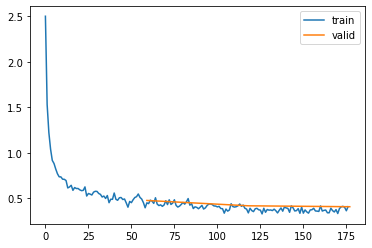

In [8]:
learn.fit(3)

#### Momentum

In [9]:
xs = torch.linspace(-4, 4, 100)
ys = 1 - (xs/3) ** 2 + torch.randn(100) * 0.1

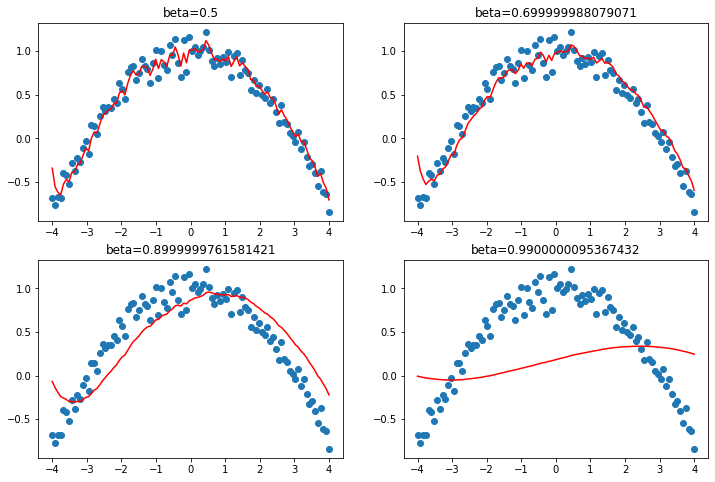

In [10]:
_, axs = plt.subplots(2,2, figsize=(12, 8))
betas = tensor([0.5, 0.7, 0.9, 0.99])
for beta, ax in zip(betas, axs.flatten()):
    ax.scatter(xs,ys)
    avg, res = tensor(0.), []
    for yi in ys:
        avg = yi.lerp(avg, beta)
        res.append(avg)
    ax.plot(xs,np.array(res), color='red');
    ax.set_title(f'beta={beta}')

In [11]:
class Momentum(SGD):
    def __init__(self, params, lr, wd=0., mom=0.9):
        super().__init__(params, lr=lr, wd=wd)
        self.mom=mom
        
    def opt_step(self, p):
        if not hasattr(p, 'grad_avg'): p.grad_avg = torch.zeros_like(p.grad)
        p.grad_avg = p.grad_avg*self.mom + p.grad*(1-self.mom)
        p -= self.lr * p.grad_avg

In [12]:
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=1.5, cbs=cbs, opt_func=Momentum)

accuracy,loss,epoch,train
0.787,0.597,0,train
0.846,0.418,0,eval
0.868,0.360,1,train
0.862,0.369,1,eval
0.886,0.312,2,train
0.867,0.362,2,eval


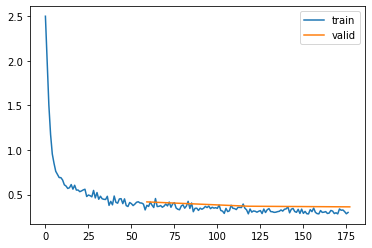

In [13]:
learn.fit(3)

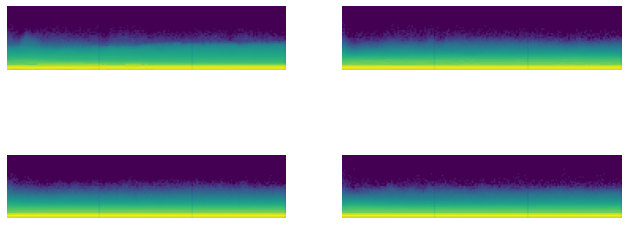

In [14]:
astats.color_dim()

#### RMSProp

In [15]:
class RMSProp(SGD):
    def __init__(self, params, lr, wd=0., sqr_mom=0.99, eps=1e-5):
        super().__init__(params, lr, wd)
        self.sqr_mom, self.eps = sqr_mom, eps
        
    def opt_step(self, p):
        if not hasattr(p, 'sqr_avg'): p.sqr_avg = p.grad ** 2
        p.sqr_avg = self.sqr_mom * p.sqr_avg + (1 - self.sqr_mom) * p.grad**2
        p -= self.lr * p.grad / (p.sqr_avg.sqrt() + self.eps)

If the p.grad**2 is large that means the variance of the gradient of parameters is large, so while updating the parameter we divide it by p.sqr_avg.sqrt() which ensures that if the gradients are consistently large -> updates are small, if the gradients are consistently small -> updates are large

accuracy,loss,epoch,train
0.766,0.664,0,train
0.822,0.481,0,eval
0.849,0.416,1,train
0.845,0.425,1,eval
0.866,0.367,2,train
0.850,0.403,2,eval


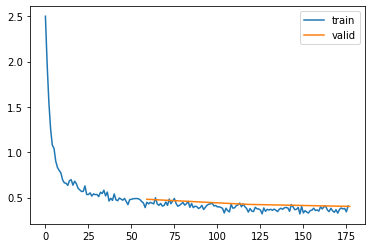

In [16]:
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=3e-3, cbs=cbs, opt_func=RMSProp)
learn.fit(3)

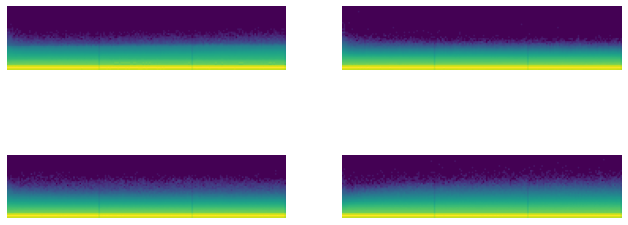

In [17]:
astats.color_dim()

#### Adam

In [18]:
class Adam(SGD):
    def __init__(self, params, lr, wd=0.1, beta1=0.9, beta2=0.99, eps=1e-5):
        super().__init__(params, lr, wd)
        self.beta1, self.beta2, self.eps= beta1, beta2, eps
        
    def opt_step(self, p):
        if not hasattr(p, 'avg'): p.avg = torch.zeros_like(p.grad.data)
        if not hasattr(p, 'sqr_avg'): p.sqr_avg = torch.zeros_like(p.grad.data)
        p.avg = self.beta1*p.avg + (1-self.beta1)*p.grad
        unbias_avg = p.avg / (1 - (self.beta1**(self.i+1))) # On early steps, the exponential average is biased toward zero, So we divide by (1 - beta1 ^ t) to correct that bias
        p.sqr_avg = self.beta2*p.sqr_avg + (1-self.beta2)*(p.grad**2)
        unbias_sqr_avg = p.sqr_avg / (1 - (self.beta2**(self.i+1)))
        p -= self.lr * unbias_avg / (unbias_sqr_avg + self.eps).sqrt()

accuracy,loss,epoch,train
0.791,0.584,0,train
0.839,0.429,0,eval
0.870,0.360,1,train
0.854,0.383,1,eval
0.886,0.312,2,train
0.874,0.343,2,eval


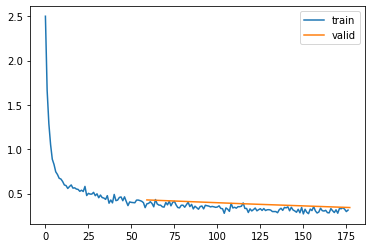

In [19]:
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=6e-3, cbs=cbs, opt_func=Adam)
learn.fit(3)

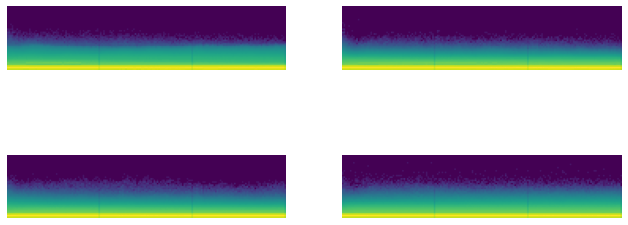

In [20]:
astats.color_dim()

### Schedulers

In [21]:
[o for o in dir(lr_scheduler) if o[0].isupper() and o[1].islower()]

['ChainedScheduler',
 'ConstantLR',
 'CosineAnnealingLR',
 'CosineAnnealingWarmRestarts',
 'Counter',
 'CyclicLR',
 'ExponentialLR',
 'LambdaLR',
 'LinearLR',
 'MultiStepLR',
 'MultiplicativeLR',
 'OneCycleLR',
 'Optimizer',
 'ReduceLROnPlateau',
 'SequentialLR',
 'StepLR']

In [22]:
list(filter(lambda x: x[0].isupper() and x[1].islower(), dir(lr_scheduler)))

['ChainedScheduler',
 'ConstantLR',
 'CosineAnnealingLR',
 'CosineAnnealingWarmRestarts',
 'Counter',
 'CyclicLR',
 'ExponentialLR',
 'LambdaLR',
 'LinearLR',
 'MultiStepLR',
 'MultiplicativeLR',
 'OneCycleLR',
 'Optimizer',
 'ReduceLROnPlateau',
 'SequentialLR',
 'StepLR']

#### filter use cases

In [23]:
items = ['123', 'abc', '456', 'def']
#list(filter(str.isalpha, items))
list(filter(lambda x: x.isalpha(), items))

['abc', 'def']

In [24]:
items = ['a', '', None, 'b', False, 'c']
list(filter(None, items))  # ['a', 'b', 'c']

['a', 'b', 'c']

In [25]:
class Opt:
    def __init__(self, name, active):
        self.name = name
        self.active = active

opts = [Opt("A", True), Opt("B", False)]
active_opts = list(filter(lambda o: o.active, opts))
active_opts

In [26]:
learn = TrainLearner(get_model(), dls, F.cross_entropy, lr=6e-3, cbs=[DeviceCB(), SingleBatchCB()])
learn.fit(1) # wouldn't do anything because raises CancelFitException after 1 batch